# Tutorial : analyse de réseaux de publications

Pour cet exemple, nous allons nous concentrer sur le cas des publications de Pubmed.

Toute démarche d'analyse de réseaux comprend au moins ces 5 étapes :

1. Collecte des données
2. Exploration et mise en forme des données
3. Construction d'un réseau avec différentes caractéristiques
4. Caractérisation du réseau et statistiques
5. Finalisation des résulats et visualisation

## 1. Collecte des données

on utilise l'existence d'une API pour pubmed et l'existence d'une bibliothèque dédiée produite par des biologistes

In [2]:
import pandas as pd
import pickle
import Bio #pip install biopython

Il y a une explication de comment utiliser l'API ici : 

In [3]:
def search(query):
    """
    Récupérer les ids d'articles liés à une requête
    """
    Entrez.email = "emilien.schultz@sciencespo.fr"
    handle = Bio.Entrez.esearch(db='pubmed',
    sort='relevance',
    retmax='250000',
    retmode='xml',
    term=query)
    results = Entrez.read(handle)
    return results

def fetch_details(id_list):
    """
    Récupérer les informations de certains articles
    """
    ids = ','.join(id_list)
    Entrez.email = "emilien.schultz@sciencespo.fr"
    handle = Bio.Entrez.efetch(db='pubmed',
    retmode='xml',id=ids)
    results = Entrez.read(handle)
    return results

https://pubmed.ncbi.nlm.nih.gov/?term=%28chloroquine+or+hydroxychloroquine%29+and+%28covid+or+corona*%29

In [23]:
studies = search('(chloroquine or hydroxychloroquine) and (covid or corona)')
studiesIdList = studies['IdList']

In [24]:
t = fetch_details(studiesIdList) #nous créons un sous ensemble de 5 articles

Sauvegarder les données brutes

In [25]:
pickle.dump(t, open("save_req.pickle","wb"))

## 2. Mise en forme des données

In [ ]:
data = pickle.load(open("save_req.pickle","rb"))['PubmedArticle']

In [27]:
len(data)

4151

Explorer le format des données

In [47]:
data[0]['MedlineCitation']['Article'].keys()

dict_keys(['ArticleDate', 'Language', 'ELocationID', 'Journal', 'ArticleTitle', 'Pagination', 'Abstract', 'AuthorList', 'PublicationTypeList'])

In [59]:
data[0]['MedlineCitation']['Article']['ArticleDate'][0]

DictElement({'Year': '2021', 'Month': '02', 'Day': '12'}, attributes={'DateType': 'Electronic'})

In [173]:
import json
#print(json.dumps(data[0]['MedlineCitation'],indent=2))

Construire l'étape de mise en forme

In [127]:
def get_authors(article):
    auteurs = []
    try: # penser à gérer les exceptions
        for i in article['MedlineCitation']['Article']['AuthorList']:
            try:
                auteurs.append(i["LastName"]+" "+i["ForeName"]) #i["ForeName"][0]
            except:
                auteurs.append(None)
    except:
        auteurs = None
    return auteurs

Construire le corpus et le mettre sous la forme d'un tableau

In [128]:
corpus = []
for article in t['PubmedArticle']:
    try:
        year = article['MedlineCitation']['Article']["ArticleDate"][0]["Year"]
    except:
        year = None
    journal = article['MedlineCitation']['Article']["Journal"]["Title"]
    title = article['MedlineCitation']['Article']['ArticleTitle']
    auteurs = get_authors(article)
    corpus.append([year,journal,title,auteurs])
    
corpus = pd.DataFrame(corpus,columns=["année","journal","titre","auteurs"])

In [129]:
corpus.head()

,année,journal,titre,auteurs
0,2021,The Cochrane database of systematic reviews,Chloroquine or hydroxychloroquine for preventi...,"[Singh Bhagteshwar, Ryan Hannah, Kredo Tamara,..."
1,2020,Clinical and experimental medicine,Emerging treatment strategies for COVID-19 inf...,"[Gavriatopoulou Maria, Ntanasis-Stathopoulos I..."
2,2020,Postgraduate medical journal,Hydroxychloroquine and COVID-19.,"[Sinha Neeraj, Balayla Galit]"
3,None,European review for medical and pharmacologica...,Efficacy of chloroquine and hydroxychloroquine...,"[Meo S A, Klonoff D C, Akram J]"
4,2020,Antiviral research,Of chloroquine and COVID-19.,"[Touret Franck, de Lamballerie Xavier]"


### Exploration

<AxesSubplot:>

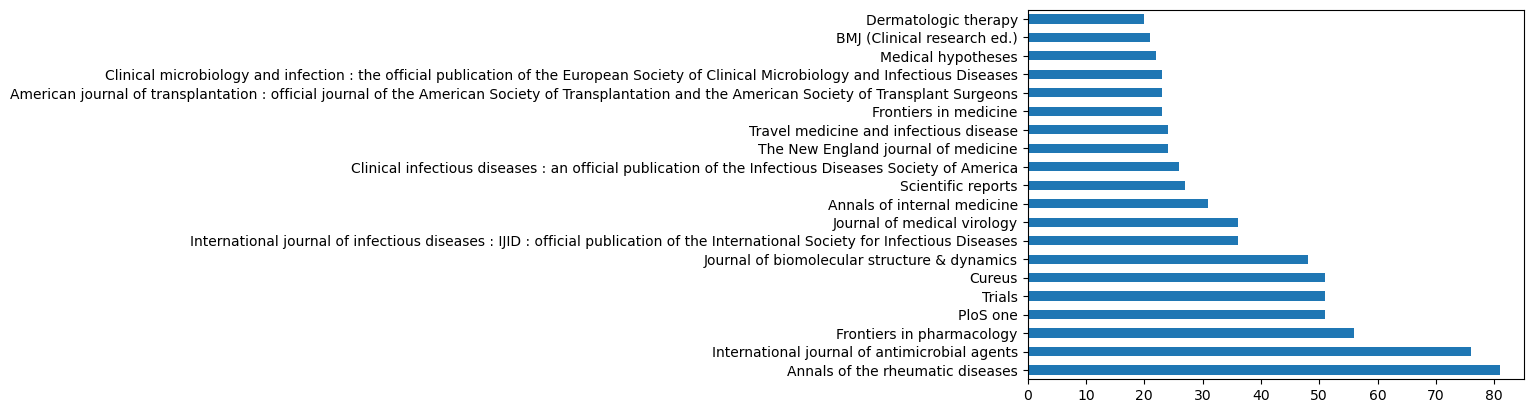

In [73]:
corpus["journal"].value_counts()[0:20].plot(kind="barh")

In [130]:
corpus["auteurs"]

0       [Singh Bhagteshwar, Ryan Hannah, Kredo Tamara,...
1       [Gavriatopoulou Maria, Ntanasis-Stathopoulos I...
2                           [Sinha Neeraj, Balayla Galit]
3                         [Meo S A, Klonoff D C, Akram J]
4                  [Touret Franck, de Lamballerie Xavier]
                              ...                        
4146    [Branković Jovica, Milovanović Vesna M, Simijo...
4147    [Solomon Daniel H, Giles Jon T, Liao Katherine...
4148    [Leal Carla Monteiro, Leitão Suzana Guimarães,...
4149    [Axfors Cathrine, Schmitt Andreas M, Janiaud P...
4150    [Trefond Ludovic, Drumez Elodie, Andre Marc, C...
Name: auteurs, Length: 4151, dtype: object

In [131]:
auteurs = []
for i in list(corpus["auteurs"].dropna()):
    for j in i:
        if pd.notnull(j):
            auteurs.append(j)
pd.Series(auteurs).value_counts().head()

Raoult Didier             35
Gautret Philippe          23
Lagier Jean-Christophe    20
Colson Philippe           19
La Scola Bernard          18
dtype: int64

Une raison d'aller vers un réseau d'auteurs ?

## 3. Construction du réseau

In [97]:
ligne

année                                                   2021
journal           Revue du rhumatisme (Ed. francaise : 1993)
titre                                       [Not Available].
auteurs    [Trefond L, Drumez E, Andre M, Costedoat-Chalu...
Name: 4150, dtype: object

In [132]:
import networkx as nx
from itertools import combinations # create combinations of a set

reseau = nx.Graph()

for idx, ligne in corpus.dropna().iterrows():
    auteurs = [i for i in ligne["auteurs"] if pd.notnull(i)]
    
    for a in auteurs:
        if not a in reseau.nodes:
            reseau.add_node(a, label=a, weight=1)
        else:
            reseau.nodes[a]["weight"] += 1    

    for i, j in combinations(auteurs, 2): 
        if not reseau.has_edge(i, j):
            reseau.add_edge(i, j, weight=1)
        else:
            reseau[i][j]["weight"] += 1

A quoi ressemble le réseau ?

Combien de composantes

In [133]:
len(reseau.nodes),len(reseau.edges)

(22735, 199887)

## 4. Caractérisation du réseau

In [134]:
nx.number_connected_components(reseau)

2056

In [135]:
nx.density(reseau)

0.0007734704589460433

Distribution des degrés

In [107]:
a= nx.degree(reseau)

In [110]:
import matplotlib.pyplot as plt

<AxesSubplot:>

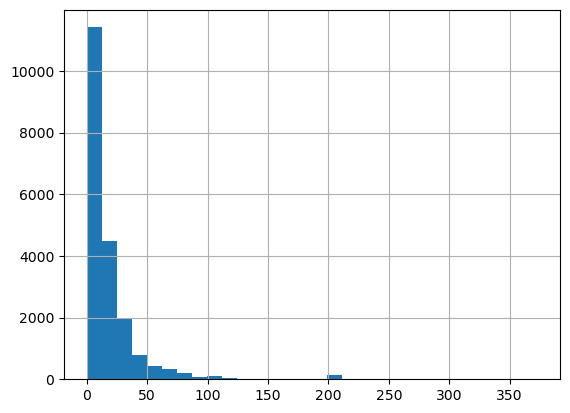

In [117]:
pd.DataFrame(a)[1].hist(bins=30)

On veut simplifier le réseau, c'est à dire ne pas garder les auteurs qui ont un degré que de 1 (qui ne sont apparus que dans un article

In [136]:
nodes = [i for i in reseau.nodes if reseau.nodes[i]["weight"]>1]
len(nodes)

2988

In [137]:
reseau_ss = reseau.subgraph(nodes)

On regarde

In [138]:
nx.number_connected_components(reseau_ss)

332

Ca donne quoi si on explore ?

In [123]:
from ipysigma import Sigma

In [139]:
Sigma(reseau_ss,node_size="weight")

Sigma(nx.Graph with 2,988 nodes and 25,535 edges)

On aimerait maintenant isoler les différentes composantes, à commencer par la composante principale

In [140]:
a = nx.connected_components(reseau_ss)

In [144]:
a = sorted([i for i in a],key=len)

In [148]:
len(a[-1])

1476

In [149]:
reseau_ss_comp1 = reseau_ss.subgraph(a[-1])

Et maintenant on veut faire un clustering

In [151]:
import networkx.algorithms.community as nx_comm
l = nx_comm.louvain_communities(reseau_ss_comp1, seed=123)

Et on veut le mettre sur le graph

In [155]:
Sigma(reseau_ss_comp1,node_size="weight",node_color=l)

Sigma(nx.Graph with 1,476 nodes and 18,041 edges)

On veut maintenant rajouter une dernière propriété : la centralité

In [161]:
bb = nx.betweenness_centrality(reseau_ss_comp1)

In [162]:
nx.set_node_attributes(reseau_ss_comp1, bb, "bb")

In [163]:
Sigma(reseau_ss_comp1,node_size="bb",node_color=l)

Sigma(nx.Graph with 1,476 nodes and 18,041 edges)

## 5. Finaliser 

Gephi est à ce titre le meilleur outil. Exportons et utilisons-le.

In [164]:
nx.write_graphml(reseau_ss_comp1,"reseau.graphml")

## 6. Aller plus loin

- réseau des mots-clés
- ajouter des caractéristiques sur les auteurs